## Which skills and job features have the biggest impact on salary?

Here we'll uncover factors that influence the salary range for Data Analysts and will specify:
- Must-have skills for Data Analysts and how they affect salary
- Top-paying analytical skills and their impact on salary
- Impact of job type (remote vs on-site) and degree requirements on salary
- Key drivers of Data Analyst salaries (SHAP analysis)

### Import Libraries

In [46]:
import ast
from pathlib import Path

import numpy as np
import pandas as pd

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MultiLabelBinarizer
from xgboost import XGBRegressor
import shap

### Load Cleaned Dataset

In [47]:
df = pd.read_csv(Path.cwd().parents[1] / 'Raw_Data' / 'df_Final.csv')

### Remove Salary Outliers
During the exploratory analysis, we identified unusually high salaries in countries with very few job postings. These outliers may result from salaries listed in local currencies, company registration addresses being used instead of actual job locations, or other inconsistencies.

Action Taken:
- Outliers were removed per job title and country to preserve meaningful comparisons.
- For countries with fewer than 5 postings, outliers were removed based on job title only to avoid skewed insights from limited data.

In [48]:
#Calculate global IQR
Q1_global = df['salary_month_avg_eur'].quantile(0.25)
Q3_global = df['salary_month_avg_eur'].quantile(0.75)
IQR_global = Q3_global - Q1_global
lower_bound_global = Q1_global - 1.5 * IQR_global
upper_bound_global = Q3_global + 1.5 * IQR_global

filtered_groups = []

#Iterate over groups manually
for (country, title), group in df.groupby(['job_country', 'job_title_short']):
    if len(group) >= 5:
        Q1 = group['salary_month_avg_eur'].quantile(0.25)
        Q3 = group['salary_month_avg_eur'].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
    else:
        lower = lower_bound_global
        upper = upper_bound_global

    filtered = group[
        (group['salary_month_avg_eur'] >= lower) &
        (group['salary_month_avg_eur'] <= upper)
    ]
    filtered_groups.append(filtered)

# Combine all groups back
df_filtered = pd.concat(filtered_groups, ignore_index=True)

print(f'Original dataset size: {len(df)}')
print(f'Filtered dataset size: {len(df_filtered)}')

Original dataset size: 22002
Filtered dataset size: 21309


### Filter Data
Although our main focus is the **European job market**, analyzing US salary trends provides valuable foresight since the United States often leads in technology adoption and skill demand. This helps us benchmark Europe’s position, anticipate emerging trends, and make more informed decisions regarding talent strategy and compensation.

In [49]:
eu_us = ['EU', 'US']

df_da_eu_us = df_filtered[
    (df_filtered['region_group'].isin(eu_us)) &
    (df_filtered['job_title_short'] == 'Data Analyst')
].copy()

To better understand how individual data analyst skills influence salaries, we first extract 'analyst_tools' data, convert the job_skills strings into actual Python lists and explode the lists so each skill appears in a separate row — making it easier to analyze skill-specific trends.

In [50]:
analyst_skills = set()
for row in df_da_eu_us['job_type_skills'].dropna().unique():
    row_dict = ast.literal_eval(row)
    analyst_skills.update(row_dict.get('analyst_tools', []))

df_da = df_da_eu_us.dropna(subset=['job_skills', 'salary_month_avg_eur']).copy()
df_da['job_skills'] = df_da['job_skills'].apply(ast.literal_eval)
df_da = df_da.explode('job_skills')
df_plot = df_da[df_da['job_skills'].isin(analyst_skills)].copy()

### Must-have skills for Data Analysts and how they affect salary

To identify essential analytical tools for data analysts, we first extract the most frequently mentioned skills from job postings. Then, we evaluate which of these skills correlate with higher salaries. This analysis helps job seekers prioritize skill acquisition based on both demand and earning potential.

In [51]:
# Find top 10 skills by number of postings
top10_by_count = (
    df_plot['job_skills']
    .value_counts()
    .head(10)
    .index.tolist()
)

df_top10_count = df_plot[df_plot['job_skills'].isin(top10_by_count)]

top10_salary_skills = (
    df_top10_count.groupby('job_skills')['salary_month_avg_eur']
    .median()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
)

top10_salary_skills['job_postings'] = top10_salary_skills['job_skills'].apply(
    lambda s: (df_plot['job_skills'] == s).sum()
)

top10_salary_skills.columns = ['skill', 'median_salary_eur', 'job_postings']
top10_salary_skills = top10_salary_skills.sort_values('median_salary_eur')

top_skills_set = set(top10_salary_skills['skill'])

# Define top 3 highest-paid skills from these top 10
top3_skills_set = set(top10_salary_skills.sort_values('median_salary_eur', ascending=False)['skill'].head(3))

df_plot['has_top_skill'] = df_plot['job_skills'].apply(lambda s: s in top3_skills_set)
df_valid = df_plot.dropna(subset=['salary_month_avg_eur'])

avg_salary = (
    df_valid.groupby('has_top_skill')['salary_month_avg_eur']
    .mean()
    .reset_index()
)

avg_salary['group'] = avg_salary['has_top_skill'].map({
    True: 'With Top 3 Skills',
    False: 'Without Top 3 Skills'
})

avg_salary['group'] = pd.Categorical(
    avg_salary['group'],
    categories=['Without Top 3 Skills', 'With Top 3 Skills'],
    ordered=True
)
avg_salary = avg_salary.sort_values('group')

with_salary = avg_salary.loc[avg_salary['group'] == 'With Top 3 Skills', 'salary_month_avg_eur'].values[0]
without_salary = avg_salary.loc[avg_salary['group'] == 'Without Top 3 Skills', 'salary_month_avg_eur'].values[0]
pct_diff = (with_salary - without_salary) / without_salary * 100

# Plotting
fig = make_subplots(
    rows=1, cols=2,
    column_widths=[0.6, 0.4],
    subplot_titles=("Top 10 In-Demand Analytical Skills Sorted by Salary", "Avg Salary: With vs Without Top 3 Skills"),
    horizontal_spacing=0.1
)

# Left: horizontal bar for median salary of top 10 skills
fig.add_trace(go.Bar(
    x=top10_salary_skills['median_salary_eur'],
    y=top10_salary_skills['skill'],
    orientation='h',
    marker=dict(color=top10_salary_skills['median_salary_eur'], colorscale='Blues'),
    text=top10_salary_skills['median_salary_eur'].round(0).astype(int),
    textposition='auto',
    name='Top Skills'
), row=1, col=1)

top_3_skills = set(top10_salary_skills.tail(3)['skill'])
ticktext = [f"<b>{s}</b>" if s in top_3_skills else s for s in top10_salary_skills['skill']]

fig.update_yaxes(
    tickmode='array',
    tickvals=top10_salary_skills['skill'],
    ticktext=ticktext,
    row=1, col=1
)

# Right: bar for avg salary with/without top 3 skills
fig.add_trace(go.Bar(
    x=avg_salary['group'],
    y=avg_salary['salary_month_avg_eur'],
    marker_color=['#9ecae1' if g == 'Without Top 3 Skills' else '#084594' for g in avg_salary['group']],
    text=avg_salary['salary_month_avg_eur'].round(0).astype(int),
    textposition='auto',
    name='Group Comparison'
), row=1, col=2)

fig.update_yaxes(
    range=[0, avg_salary['salary_month_avg_eur'].max() * 1.2],
    row=1, col=2
)

fig.add_annotation(
    x=0.5,
    y=max(avg_salary['salary_month_avg_eur']) * 1.1,
    text=f'+{pct_diff:.1f}%',
    showarrow=False,
    font=dict(size=14, color='gray'),
    xref='x2',
    yref='y2'
)

fig.update_layout(
    height=500,
    width=1000,
    template='plotly_white',
    showlegend=False,
    margin=dict(t=60, b=40, l=60, r=40),
)

fig.update_xaxes(title_text='Median Salary, EUR', row=1, col=1)
fig.update_xaxes(showticklabels=False, row=1, col=1)
fig.update_yaxes(title_text='', row=1, col=1)
fig.update_xaxes(title_text='', row=1, col=2)
fig.update_yaxes(title_text='', showticklabels=False, row=1, col=2)

fig.show()

- With Top 3 Skills: Job posting has at least one of the top 3 skills.
- Without Top 3 Skills: Job posting has none of the top 3 skills.

Tools like **Looker**, **Tableau**, and **Power BI** top the list, offering the highest salary within the top-10 in-demand skills. Notably, candidates with at least one of the top 3 tools command an 8.2% higher average salary compared to those without. This emphasizes the strategic value of learning high-demand BI tools — both for entering the job market and for accelerating salary growth.

### Top-paying analytical skills and their impact on salary

While some tools are commonly requested, others—though less frequent—offer significantly higher salaries. This section uncovers the most lucrative analytical skills and compares salary outcomes for analysts who possess them versus those who don’t.

In [52]:
# Top 10 highest paid skills
top10_salary_skills = (
    df_plot.groupby('job_skills')['salary_month_avg_eur']
    .median()
    .sort_values(ascending=False)
    .head(10)
    .reset_index()
)

top10_salary_skills.columns = ['skill', 'median_salary_eur']
top10_salary_skills = top10_salary_skills.sort_values('median_salary_eur')
top_skills_set = set(top10_salary_skills['skill'])

# With vs Without top 3 highest-paid skills
top3_skills_set = set(top10_salary_skills.sort_values('median_salary_eur', ascending=False)['skill'].head(3))

df_plot['has_top_skill'] = df_plot['job_skills'].apply(lambda s: s in top3_skills_set)
df_valid = df_plot.dropna(subset=['salary_month_avg_eur'])

avg_salary = (
    df_valid.groupby('has_top_skill')['salary_month_avg_eur']
    .mean()
    .reset_index()
)

avg_salary['group'] = avg_salary['has_top_skill'].map({
    True: 'With Top 3 Skills',
    False: 'Without Top 3 Skills'
})

with_salary = avg_salary.loc[avg_salary['group'] == 'With Top 3 Skills', 'salary_month_avg_eur'].values[0]
without_salary = avg_salary.loc[avg_salary['group'] == 'Without Top 3 Skills', 'salary_month_avg_eur'].values[0]
pct_diff = (with_salary - without_salary) / without_salary * 100

# Plotting
fig = make_subplots(
    rows=1, cols=2,
    column_widths=[0.6, 0.4],
    subplot_titles=("Top 10 Highest Paid Analytical Skills", "Avg Salary: With vs Without Top 3 Skills"),
    horizontal_spacing=0.1
)

fig.add_trace(go.Bar(
    x=top10_salary_skills['median_salary_eur'],
    y=top10_salary_skills['skill'],
    orientation='h',
    marker=dict(color=top10_salary_skills['median_salary_eur'], colorscale='Blues'),
    text=top10_salary_skills['median_salary_eur'].round(0).astype(int),
    textposition='auto',
    name='Top Skills'
), row=1, col=1)

top_3_skills = set(top10_salary_skills.tail(3)['skill'])
ticktext = [f"<b>{s}</b>" if s in top_3_skills else s for s in top10_salary_skills['skill']]

fig.update_yaxes(
    tickmode='array',
    tickvals=top10_salary_skills['skill'],
    ticktext=ticktext,
    row=1, col=1
)

fig.add_trace(go.Bar(
    x=avg_salary['group'],
    y=avg_salary['salary_month_avg_eur'],
    marker_color=['#9ecae1' if g == 'Without Top 3 Skills' else '#084594' for g in avg_salary['group']],
    text=avg_salary['salary_month_avg_eur'].round(0).astype(int),
    textposition='auto',
    name='Group Comparison'
), row=1, col=2)

fig.update_yaxes(
    range=[0, avg_salary['salary_month_avg_eur'].max() * 1.2],
    row=1, col=2
)

fig.add_annotation(
    x=0.5,
    y=max(avg_salary['salary_month_avg_eur']) * 1.1,
    text=f'+{pct_diff:.1f}%',
    showarrow=False,
    font=dict(size=14, color='gray'),
    xref='x2',
    yref='y2'
)

fig.update_layout(
    height=500,
    width=1000,
    template='plotly_white',
    showlegend=False,
    margin=dict(t=60, b=40, l=60, r=40),
)

fig.update_xaxes(title_text='Median Salary, EUR', row=1, col=1)
fig.update_xaxes(showticklabels=False, row=1, col=1)
fig.update_yaxes(title_text='', row=1, col=1)
fig.update_xaxes(title_text='', row=1, col=2)
fig.update_yaxes(title_text='', showticklabels=False, row=1, col=2)

fig.show()

- With Top 3 Skills: Job posting has at least one of the top 3 skills.
- Without Top 3 Skills: Job posting has none of the top 3 skills.

Job seekers can boost their salary by over 15% with top-3 highest-paid analyst skills that are **Splunk**, **Alteryx**, and **Looker**. Splunk leads the list but is a niche tool focused on IT and security, making it less common in typical analyst roles. Alteryx specializes in data preparation and automation, offering both high pay and broader relevance. Looker stands out as the most strategic choice—it's both well-paid and widely used in modern analytics teams.

### Impact of job type (remote vs on-site) and degree requirements on salary

Job flexibility and educational requirements can influence compensation. Here, we examine how remote work and the presence of a degree requirement affect average analyst salaries across the EU and US.

In [53]:
# Prepare data
remote_salary_avg = df_da_eu_us.groupby('job_work_from_home')['salary_month_avg_eur'].mean().reset_index()
remote_salary_avg['Remote Work'] = remote_salary_avg['job_work_from_home'].map({True: 'Remote', False: 'On-site'})

degree_salary_avg = df_da_eu_us.groupby('job_no_degree_mention')['salary_month_avg_eur'].mean().reset_index()
degree_salary_avg['Degree Mention'] = degree_salary_avg['job_no_degree_mention'].map({True: 'No Degree Mentioned', False: 'Degree Mentioned'})

remote_order = ['On-site', 'Remote']
degree_order = ['No Degree Mentioned', 'Degree Mentioned']

colors = ['#9ecae1', '#084594'] 

remote_salary_avg = remote_salary_avg.set_index('Remote Work').loc[remote_order].reset_index()
degree_salary_avg = degree_salary_avg.set_index('Degree Mention').loc[degree_order].reset_index()

# Calculate % differences
def calc_pct_diff(group_df):
    low = group_df['salary_month_avg_eur'].iloc[0]
    high = group_df['salary_month_avg_eur'].iloc[1]
    return (high - low) / low * 100

remote_pct_diff = calc_pct_diff(remote_salary_avg)
degree_pct_diff = calc_pct_diff(degree_salary_avg)

fig = make_subplots(rows=1, cols=2, subplot_titles=('Avg Salary by Remote Work', 'Avg Salary by Degree Mention'))

# Remote Work
fig.add_trace(
    go.Bar(
        x=remote_salary_avg['Remote Work'],
        y=remote_salary_avg['salary_month_avg_eur'],
        marker_color=colors,
        showlegend=False,
        text=remote_salary_avg['salary_month_avg_eur'].round(0).astype(int),
        textposition='auto'
    ),
    row=1,
    col=1
)

# Degree Mention
fig.add_trace(
    go.Bar(
        x=degree_salary_avg['Degree Mention'],
        y=degree_salary_avg['salary_month_avg_eur'],
        marker_color=colors,
        showlegend=False,
        text=degree_salary_avg['salary_month_avg_eur'].round(0).astype(int),
        textposition='auto'
    ),
    row=1,
    col=2
)

fig.add_annotation(
    x=0.5, 
    y=max(remote_salary_avg['salary_month_avg_eur']) * 1.2,
    xref='x domain',  # first subplot x axis
    yref='y',         # first subplot y axis
    text=f'+{remote_pct_diff:.1f}%',
    showarrow=False,
    font=dict(color='grey', size=14)
)

fig.add_annotation(
    x=0.5, 
    y=max(degree_salary_avg['salary_month_avg_eur']) * 1.2,
    xref='x2 domain', # second subplot x axis
    yref='y2',        # second subplot y axis
    text=f'+{degree_pct_diff:.1f}%',
    showarrow=False,
    font=dict(color='grey', size=14)
)

# Update layout
fig.update_yaxes(
    showticklabels=False,
    showgrid=False,
    zeroline=False
)

fig.update_yaxes(
    showticklabels=False,
    showgrid=False,
    zeroline=False
)

for ann in fig['layout']['annotations']: ann['y'] += 0.05

fig.update_layout(
    height=400,
    width=800,
    yaxis_title='',
    template='plotly_white',
)

fig.show()

### Key drivers of Data Analyst salaries (SHAP analysis)

To identify which job attributes most strongly influence salaries, we apply SHAP analysis on an XGBoost model with following steps:

- Duplicate the original dataset to safely perform data transformations without altering the source.
- Prepare feature columns for analysis:
    - invert job_no_degree_mention,
    - convert job_skills into individual binary (0/1) columns using multi-label binarization,
    - make sure all boolean features are numerical (0/1) for model compatibility,
    - combine relevant features (remote status, degree mention, and skills) into a feature matrix, 
    - set the target variable as the average monthly salary in EUR.
- Train a Machine Learning Model: 
    - split the data into training and test sets (80/20),
    - use a regression model (XGBoost) to learn patterns and predict salaries, 
    - evaluate performance using R² score.
- Use SHAP to understand how each feature contributes to the model’s predictions for individual samples.
- Calculate and rank features by their average impact (SHAP value) across all predictions.

Test R^2 Score: 0.133
SHAP Feature Importance (as % impact) for Top 5 Features:
skill_excel: 15.7%
skill_python: 10.6%
skill_sql: 5.4%
degree_mentioned: 4.5%
skill_tableau: 4.4%


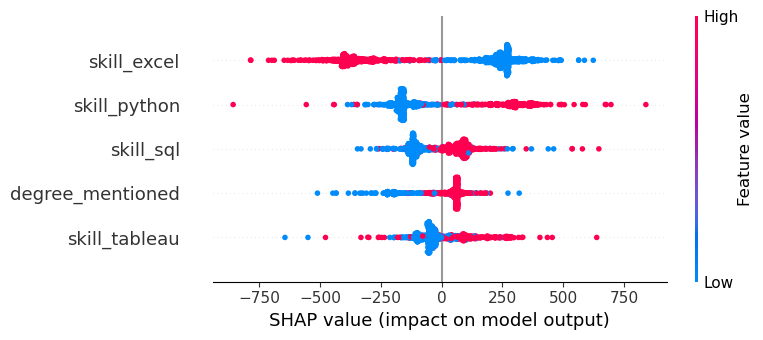

In [56]:
df_model = df_da_eu_us.copy()
df_model['degree_mentioned'] = ~df_model['job_no_degree_mention']

def ensure_list(x):
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except Exception:
            return []
    elif isinstance(x, list):
        return x
    else:
        return []

df_model['job_skills'] = df_model['job_skills'].apply(ensure_list)

# Binarize job_skills
mlb = MultiLabelBinarizer()
skills_encoded = pd.DataFrame(
    mlb.fit_transform(df_model['job_skills']),
    columns=[f"skill_{s}" for s in mlb.classes_],
    index=df_model.index
)

# Ensure boolean features are numeric
df_model['job_work_from_home'] = df_model['job_work_from_home'].astype(int)
df_model['degree_mentioned'] = df_model['degree_mentioned'].astype(int)

# Combine features
features = pd.concat([
    df_model[['job_work_from_home', 'degree_mentioned']],
    skills_encoded
], axis=1)

# Target variable
target = df_model['salary_month_avg_eur']

# Train/Test Split and Model Training
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

model = XGBRegressor(random_state=42)
model.fit(X_train, y_train)

score = model.score(X_test, y_test)
print(f"Test R^2 Score: {score:.3f}")

# SHAP Analysis
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

mean_abs_shap = np.abs(shap_values).mean(axis=0)
shap_importance = pd.DataFrame({
    'feature': X_test.columns,
    'mean_abs_shap': mean_abs_shap
}).sort_values(by='mean_abs_shap', ascending=False)

top5_features = shap_importance.head(5)['feature'].tolist()
top5_indices = [X_test.columns.get_loc(f) for f in top5_features]

shap_values_top5 = shap_values[:, top5_indices]
X_test_top5 = X_test[top5_features]

total_shap = shap_importance['mean_abs_shap'].sum()
shap_importance['percentage_impact'] = 100 * shap_importance['mean_abs_shap'] / total_shap
top5_impacts = shap_importance.set_index('feature').loc[top5_features]['percentage_impact']

print('SHAP Feature Importance (as % impact) for Top 5 Features:')
for feat, impact in top5_impacts.items():
    print(f"{feat}: {impact:.1f}%")

shap.summary_plot(shap_values_top5, X_test_top5, feature_names=top5_features)

### Key insights from SHAP feature importance

The model explains only 13.3% of the variation in salaries, so many salary-driving factors are not captured in the current features Despite that, the SHAP values still give useful signals about which features have the highest impact on salaries:

- **Excel** (15.7% impact): the most impactful feature on salary. Mentioning Excel in a job posting is strongly associated with higher salary. It means that Excel is still a core skill for Data Analysts and often correlates with jobs that pay more, possibly due to its use in business-critical reporting or financial analysis.
- **Python** (10.6%): strongly associated with higher salaries, especially in roles involving automation, or machine learning.
- **SQL** (5.4%): is essential but has a moderate impact compared to Excel and Python. It's a baseline skill, so it doesn’t necessarily distinguish higher-paying roles — but still crucial.
- **No Degree Mention** (4.5%): slightly associated with lower salaries, possibly reflecting more inclusive or junior positions.
- **Tableau** (4.4%): is valued in visualization-heavy roles and may slightly boost salary expectations.

**Summary**: While modern tools like Python increase salary, traditional tools like Excel still carry major weight — possibly due to their presence in senior business roles. Mention both Excel and Python on the aplcation makes the candidate more attractive to employers and can lead to better salary offers.

### Summary:
Job seekers aiming for a **Data Analyst** role should focus on learning one of the most in-demand tools, like **Looker**, **Tableau**, or **Power BI**. To boost their salary further, mastering a niche tool such as **Splunk** or **Alteryx** helps, with Looker being a strong choice due to its high demand and top-tier pay. 

Salary differences between **remote** and **in-office** roles generally even out, suggesting that compensation is driven more by skill and value delivered than work location. Notably, job postings that do not mention **degree requirements** are slightly associated with lower salaries, possibly reflecting more junior positions.

SHAP analysis showed that **Excel** is still a **key skill** for Data Analysts — the most impactful on salary — while **Python** strongly correlates with higher pay. Highlighting both tools when applying, could improve chances of landing better-paying roles.